In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
from collections import defaultdict
import os

import matplotlib.pyplot as plt
import scipy.stats

from jax import pure_callback, random
import jax.numpy as jnp
import optax

import numpyro
from numpyro import handlers
from numpyro.contrib.funsor import config_enumerate, infer_discrete
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import SVI, TraceEnum_ELBO, init_to_value
from numpyro.infer.autoguide import AutoDelta

/Users/jaminkim/anaconda3/envs/pymc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from pybaseball import statcast

new_pbp_2024 = statcast("2024-03-27", "2024-09-30")

This is a large query, it may take a moment to complete


/Users/jaminkim/anaconda3/envs/pymc_env/lib/python3.10/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  1%|▏                                          | 1/188 [00:00<02:35,  1.21it/s]/Users/jaminkim/anaconda3/envs/pymc_env/lib/python3.10/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_date

In [7]:
from baseball_utilities.display import *
set_pandas_display_all()

In [8]:
new_pbp_2024

pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
202          FF 2024-09-30           97.4           -2.1           4.88   
207          SL 2024-09-30           90.7          -2.14           5.06   
209          SL 2024-09-30           91.1          -2.07           5.14   
215          SL 2024-09-30           91.3          -2.05           5.07   
219          SL 2024-09-30           89.1          -2.13           5.15   
...         ...        ...            ...            ...            ...   
3271         CU 2024-03-28           78.0          -2.24           5.69   
3321         FF 2024-03-28           96.7          -2.41           5.34   
3551         CU 2024-03-28           78.1          -2.27           5.62   
3618         FF 2024-03-28           97.0           -2.4           5.36   
3729         FF 2024-03-28           96.1          -2.39           5.33   

          player_name  batter  pitcher     events      description  spin_dir  \
202       Díaz, Edwin  518595   621242  field_out    hit_into_play      <NA>   
207       Díaz, Edwin  518595   621242        NaN             ball      <NA>   
209       Díaz, Edwin  518595   621242        NaN  swinging_strike      <NA>   
215       Díaz, Edwin  518595   621242        NaN             ball      <NA>   
219       Díaz, Edwin  518595   621242        NaN  swinging_strike      <NA>   
...               ...     ...      ...        ...              ...       ...   
3271  Eovaldi, Nathan  641355   543135        NaN    called_strike      <NA>   
3321  Eovaldi, Nathan  673548   543135  field_out    hit_into_play      <NA>   
3551  Eovaldi, Nathan  673548   543135        NaN    called_strike      <NA>   
3618  Eovaldi, Nathan  673548   543135        NaN             ball      <NA>   
3729  Eovaldi, Nathan  664023   543135  field_out    hit_into_play      <NA>   

      spin_rate_deprecated  break_angle_deprecated  break_length_deprecated  \
202                   <NA>                    <NA>                     <NA>   
207                   <NA>                    <NA>                     <NA>   
209                   <NA>                    <NA>                     <NA>   
215                   <NA>                    <NA>                     <NA>   
219                   <NA>                    <NA>                     <NA>   
...                    ...                     ...                      ...   
3271                  <NA>                    <NA>                     <NA>   
3321                  <NA>                    <NA>                     <NA>   
3551                  <NA>                    <NA>                     <NA>   
3618                  <NA>                    <NA>                     <NA>   
3729                  <NA>                    <NA>                     <NA>   

      zone  \
202      3   
207     14   
209      9   
215     14   
219     14   
...    ...   
3271     5   
3321     2   
3551     9   
3618    14   
3729     4   

                                                                                        des  \
202   Travis d'Arnaud grounds out, shortstop Francisco Lindor to first baseman Pete Alonso.   
207   Travis d'Arnaud grounds out, shortstop Francisco Lindor to first baseman Pete Alonso.   
209   Travis d'Arnaud grounds out, shortstop Francisco Lindor to first baseman Pete Alonso.   
215   Travis d'Arnaud grounds out, shortstop Francisco Lindor to first baseman Pete Alonso.   
219   Travis d'Arnaud grounds out, shortstop Francisco Lindor to first baseman Pete Alonso.   
...                                                                                     ...   
3271                       Cody Bellinger lines out sharply to right fielder Adolis García.   
3321      Seiya Suzuki grounds out, pitcher Nathan Eovaldi to first baseman Ezequiel Duran.   
3551      Seiya Suzuki grounds out, pitcher Nathan Eovaldi to first baseman Ezequiel Duran.   
3618      Seiya Suzuki grounds out, pitcher Nathan Eovaldi to first baseman

In [10]:
swing_2024[['batter_name', 'bat_speed', 'swing_length']].head(10)


batter_name  bat_speed  swing_length
0   Shea Langeliers       74.5           7.0
1   Shea Langeliers       74.5           8.1
2  Tyler Soderstrom       73.6           8.1
3   Lawrence Butler       76.2           7.4
4      Brett Harris       71.8           7.2
5      Brett Harris       71.2           7.7
6         JJ Bleday       75.4           7.4
7    Miguel Andújar       78.7           7.5
8      Brent Rooker       69.7           8.0
9      Brent Rooker       74.9           7.4

In [4]:
oneil_cruz = swing_2024[swing_2024['batter_name'].isin(["Oneil Cruz"])]

In [20]:
shea_tyler = swing_2024[swing_2024['batter_name'].isin(["Luis Arráez", "Steven Kwan"])]

In [5]:
oneil_cruz

pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
421            FC 2024-06-23           89.6          -1.06           6.47   
957            FC 2024-07-11           88.4          -1.09           6.28   
968            ST 2024-07-11           79.6          -1.11           6.23   
969            FF 2024-07-11           91.5          -1.06           6.25   
970            FC 2024-07-11           87.3          -1.08           6.33   
...           ...        ...            ...            ...            ...   
320848         SL 2024-05-13           93.8          -2.42           6.22   
321701         CU 2024-09-25           84.6           0.64           6.48   
322464         SL 2024-06-09           81.9          -1.43           6.04   
322465         FF 2024-06-09           94.1          -1.54           5.85   
322483         CH 2024-06-09           85.4          -1.55           5.99   

           player_name  batter  pitcher     events      description  ...  \
421      Civale, Aaron  665833   650644       None  swinging_strike  ...   
957      Civale, Aaron  665833   650644     single    hit_into_play  ...   
968      Civale, Aaron  665833   650644       None  swinging_strike  ...   
969      Civale, Aaron  665833   650644       None             foul  ...   
970      Civale, Aaron  665833   650644       None             foul  ...   
...                ...     ...      ...        ...              ...  ...   
320848  Vieira, Thyago  665833   600986     single    hit_into_play  ...   
321701    Ashby, Aaron  665833   676879  field_out    hit_into_play  ...   
322464    Ober, Bailey  665833   641927       None  swinging_strike  ...   
322465    Ober, Bailey  665833   641927     single    hit_into_play  ...   
322483    Ober, Bailey  665833   641927  field_out    hit_into_play  ...   

       pitcher_days_until_next_game batter_days_until_next_game  \
421                             6.0                         1.0   
957                            10.0                         2.0   
968                            10.0                         2.0   
969                            10.0                         2.0   
970                            10.0                         2.0   
...                             ...                         ...   
320848                          6.0                         1.0   
321701                          3.0                         1.0   
322464                          7.0                         2.0   
322465                          7.0                         2.0   
322483                          7.0                         2.0   

       api_break_z_with_gravity api_break_x_arm  api_break_x_batter_in  \
421                        2.05           -0.40                   0.40   
957                        2.18           -0.32                   0.32   
968                        3.81           -1.18                   1.18   
969                        1.23            0.22                  -0.22   
970                        2.48           -0.60                   0.60   
...                         ...             ...                    ...   
320848                     2.25           -0.04                   0.04   
321701                     4.69           -0.66                  -0.66   
322464                     3.81           -0.81                   0.81   
322465                     1.50            0.99                  -0.99   
322483                     2.71            1.29                  -1.29   

       arm_angle total_pitches_game preferred_pitch avg_preferred_ff_velocity  \
421         50.0                 61              FF                      92.0   
957         46.6                100              FF                      92.0   
968         41.0                100              FF                      92.0   
969         42.4                100              FF                      92.0   
970         47.4                100              FF                   

In [12]:
sns.scatterplot(data = shea_tyler, x = 'swing_length', y = 'bat_speed', hue = 'batter_name')
plt.title("Swing Length vs Bat Speed for Steven Kwan & Luis Arraez")
plt.xlabel("Swing Length (ft)")
plt.ylabel("Bat Speed (mph)") 
plt.show()

NameError: name 'shea_tyler' is not defined

In [7]:
sns.scatterplot(data = oneil_cruz, x = 'swing_length', y = 'bat_speed', hue = 'batter_name')
plt.title("Swing Length vs Bat Speed for Oneil Cruz")
plt.xlabel("Swing Length (ft)")
plt.ylabel("Bat speed (mph)")
plt.show()

NameError: name 'sns' is not defined

<Axes: xlabel='swing_length', ylabel='bat_speed'>

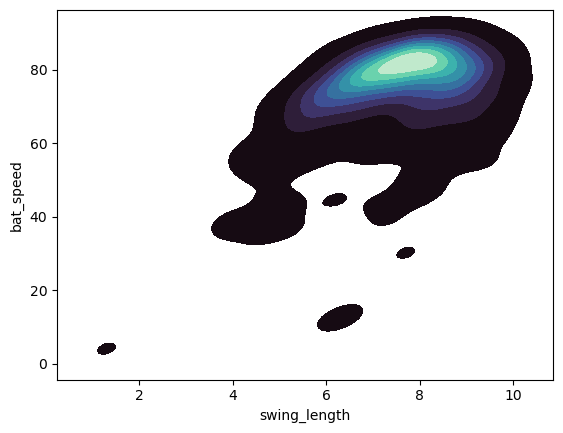

In [26]:
sns.kdeplot(
    data=pete_alonso,
    x="swing_length", y = "bat_speed",
    fill=True, thresh = 0.01, cmap = "mako"
)

In [28]:
oneil_cruz = pete_alonso

In [29]:
X = oneil_cruz[["swing_length", "bat_speed"]].dropna().to_numpy()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
oneil_cruz = oneil_cruz[
    oneil_cruz[["plate_x", "plate_z", "effective_speed"]].notna().all(axis=1) & 
    ~np.isinf(oneil_cruz[["plate_x", "plate_z", "effective_speed"]]).any(axis=1)
]

In [77]:
import pygam
print("scipy version:", scipy.__version__)
print("pygam version:", pygam.__version__)


scipy version: 1.15.2
pygam version: 0.9.1


In [1]:
import scipy
print("scipy version:", scipy.__version__)

scipy version: 1.10.1


In [21]:
from pygam import LinearGAM, s


X = oneil_cruz[["plate_x", "plate_z", "effective_speed"]].to_numpy()

gam_speed = LinearGAM(s(0) + s(1) + s(2)).fit(X, oneil_cruz["bat_speed"])
gam_length = LinearGAM(s(0) + s(1) + s(2)).fit(X, oneil_cruz["swing_length"])

oneil_cruz.loc[:,"bat_speed_pred"] = gam_speed.predict(X)
oneil_cruz.loc[:,"swing_length_pred"] = gam_length.predict(X)

oneil_cruz.loc[:, "bat_speed_residual"]  = oneil_cruz["bat_speed"] - oneil_cruz["bat_speed_pred"]
oneil_cruz.loc[:, "swing_length_residual"] = oneil_cruz["swing_length"] - oneil_cruz["swing_length_pred"]

#gam_speed = LinearGAM(s(0) + s(1) + s(2)).fit(X, oneil_cruz["bat_speed"])
#gam_length = LinearGAM(s(0) + s(1) + s(2)).fit(X, oneil_cruz["swing_length"])


In [26]:
oneil_cruz.to_csv("oneil_cruz_residuals.csv", index=False)

In [3]:
oneil_cruz = pd.read_csv("oneil_cruz_residuals.csv")


In [4]:
oneil_cruz

pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0           FC  2024-06-23           89.6          -1.06           6.47   
1           FC  2024-07-11           88.4          -1.09           6.28   
2           ST  2024-07-11           79.6          -1.11           6.23   
3           FF  2024-07-11           91.5          -1.06           6.25   
4           FC  2024-07-11           87.3          -1.08           6.33   
..         ...         ...            ...            ...            ...   
955         SL  2024-05-13           93.8          -2.42           6.22   
956         CU  2024-09-25           84.6           0.64           6.48   
957         SL  2024-06-09           81.9          -1.43           6.04   
958         FF  2024-06-09           94.1          -1.54           5.85   
959         CH  2024-06-09           85.4          -1.55           5.99   

        player_name  batter  pitcher     events      description  ...  \
0     Civale, Aaron  665833   650644        NaN  swinging_strike  ...   
1     Civale, Aaron  665833   650644     single    hit_into_play  ...   
2     Civale, Aaron  665833   650644        NaN  swinging_strike  ...   
3     Civale, Aaron  665833   650644        NaN             foul  ...   
4     Civale, Aaron  665833   650644        NaN             foul  ...   
..              ...     ...      ...        ...              ...  ...   
955  Vieira, Thyago  665833   600986     single    hit_into_play  ...   
956    Ashby, Aaron  665833   676879  field_out    hit_into_play  ...   
957    Ober, Bailey  665833   641927        NaN  swinging_strike  ...   
958    Ober, Bailey  665833   641927     single    hit_into_play  ...   
959    Ober, Bailey  665833   641927  field_out    hit_into_play  ...   

     api_break_x_batter_in  arm_angle  total_pitches_game  preferred_pitch  \
0                     0.40       50.0                  61               FF   
1                     0.32       46.6                 100               FF   
2                     1.18       41.0                 100               FF   
3                    -0.22       42.4                 100               FF   
4                     0.60       47.4                 100               FF   
..                     ...        ...                 ...              ...   
955                   0.04       51.4                  19               FF   
956                  -0.66       53.1                  25               FF   
957                   0.81       34.4                  85               FF   
958                  -0.99       32.0                  85               FF   
959                  -1.29       31.7                  85               FF   

     avg_preferred_ff_velocity batter_name bat_speed_pred swing_length_pred  \
0                         92.0  Oneil Cruz      73.005544          6.446324   
1                         92.0  Oneil Cruz      80.751234          8.004638   
2                         92.0  Oneil Cruz      74.875570          8.610594   
3                         92.0  Oneil Cruz      67.005366          6.151516   
4                         92.0  Oneil Cruz      71.613862          6.960945   
..                         ...         ...            ...               ...   
955                       97.8  Oneil Cruz      79.440962          6.919727   
956                       96.2  Oneil Cruz      78.508798          7.869704   
957                       91.7  Oneil Cruz      78.119897          7.986815   
958                       91.7  Oneil Cruz      74.506805          6.224665   
959                       91.7  Oneil Cruz      78.835849          7.943150   

    bat_speed_residual swing_length_residual  
0             6.394456              0.153676  
1            -1.451234              0.895362  
2            -1.575570              0.689406  
3             2.194634              0.448484  
4            -6.713862             -0.560945  
..                 ...                   ...  
955        

In [7]:
Y_data = oneil_cruz[["bat_speed_residual", "swing_length_residual"]].to_numpy()
good_rows = np.isfinite(Y_data).all(axis=1)
Y_data = Y_data[good_rows]
n = Y_data.shape[0]

In [31]:
def swing_mixture_model(y):
    n, d = y.shape

    mu_fg = numpyro.sample("mu_fg", dist.Normal(0,5).expand([d]))
    sigma_fg = numpyro.sample("sigma_fg", dist.HalfNormal(5).expand([d]))
    fg_dist = dist.Independent(dist.Normal(mu_fg, sigma_fg),1)

    mu_bg = numpyro.sample("mu_bg", dist.Normal(0,5).expand([d]))
    sigma_bg = numpyro.sample("sigma_bg", dist.HalfNormal(5).expand([d]))
    bg_dist = dist.Independent(dist.Normal(mu_bg, sigma_bg), 1)

    components = [fg_dist, bg_dist]

    Q = numpyro.sample("Q", dist.Uniform(0, 1))
    mix = dist.Categorical(probs=jnp.array([Q , 1- Q]))

    with numpyro.plate("data", n):
        logp_fg = fg_dist.log_prob(y)
        logp_bg = bg_dist.log_prob(y)

        log_mixture = jnp.logaddexp(
            jnp.log(Q) + logp_fg,
            jnp.log(1.0 - Q) + logp_bg
        )

        numpyro.factor("likelihood", log_mixture.sum())

In [32]:
import jax
import jax.numpy as jno
from numpyro.infer import MCMC, NUTS, Predictive
nuts_kernel = NUTS(swing_mixture_model)
mcmc = MCMC(nuts_kernel, num_warmup = 1000, num_samples = 1000, num_chains = 2)
mcmc.run(jax.random.PRNGKey(0), y = Y_data)`
mcmc.print_summary()

/var/folders/s2/nj72w9kx55v5zn8_gfnr84qr0000gn/T/ipykernel_1483/1573655400.py:5: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup = 1000, num_samples = 1000, num_chains = 2)
sample: 100%|█| 2000/2000 [00:02<00:00, 760.30it/s, 31 steps of size 7.95e-02. a
sample: 100%|█| 2000/2000 [00:02<00:00, 676.24it/s, 31 steps of size 4.99e-02. a



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          Q      0.91      0.00      0.91      0.91      0.91    597.80      1.00
   mu_bg[0]    -14.88      0.06    -14.88    -14.99    -14.78    621.73      1.00
   mu_bg[1]     -1.06      0.00     -1.06     -1.06     -1.05    979.95      1.00
   mu_fg[0]      1.54      0.01      1.54      1.53      1.55    825.19      1.00
   mu_fg[1]      0.11      0.00      0.11      0.11      0.11   1307.55      1.00
sigma_bg[0]     12.69      0.03     12.69     12.64     12.75   1307.05      1.00
sigma_bg[1]      0.68      0.00      0.68      0.68      0.69   1965.83      1.00
sigma_fg[0]      4.94      0.00      4.94      4.94      4.95   1026.92      1.00
sigma_fg[1]      0.55      0.00      0.55      0.55      0.55   1730.65      1.00

Number of divergences: 0


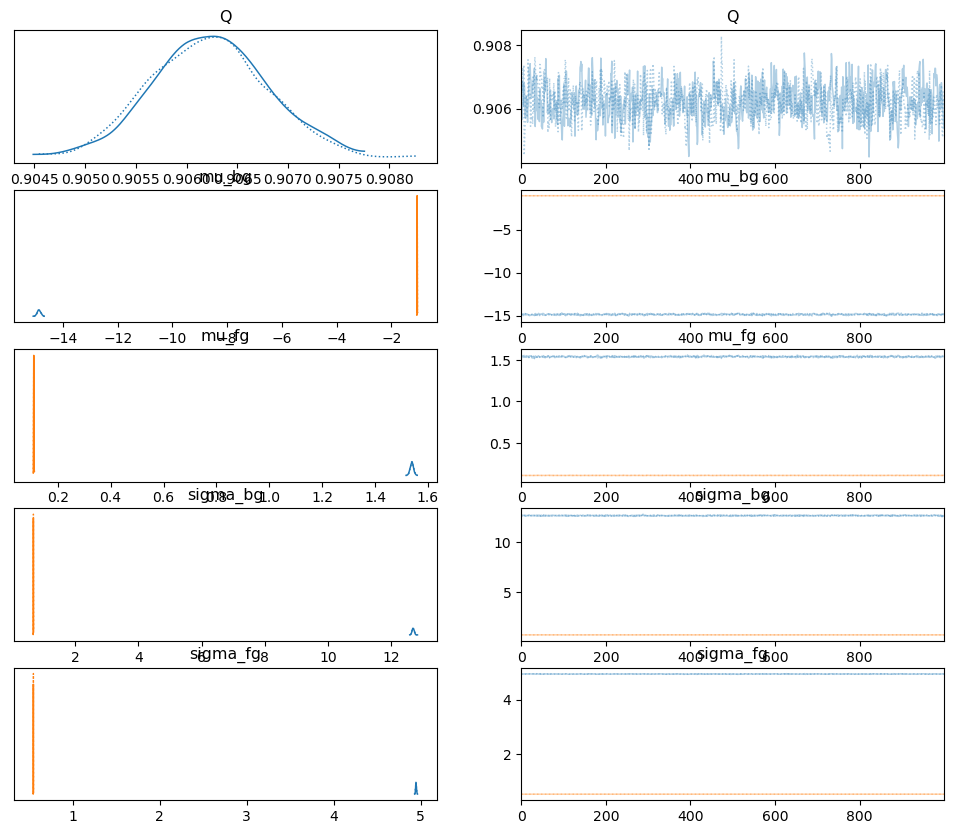

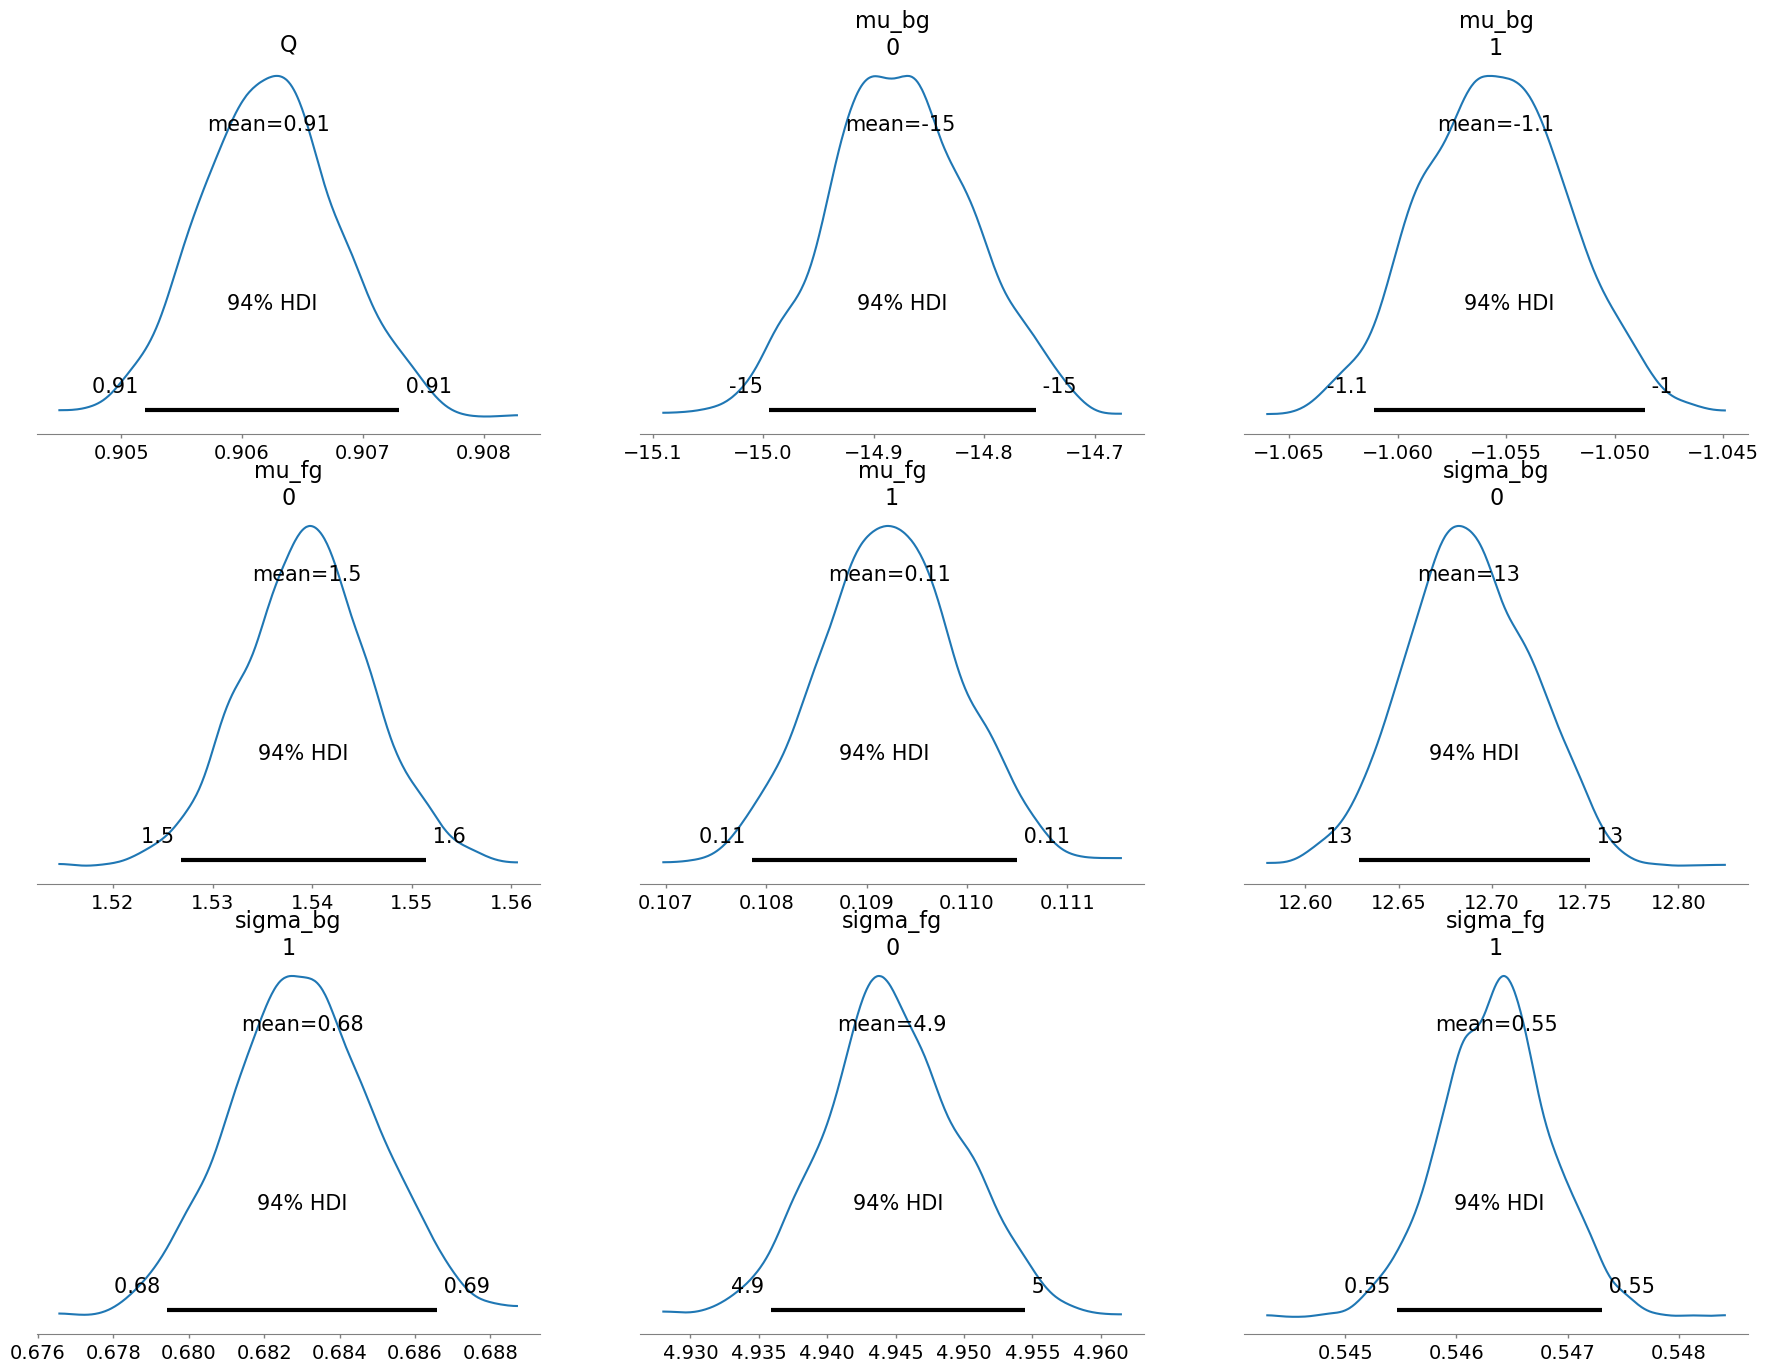

In [35]:
import arviz as az
idata = az.from_numpyro(mcmc)

az.plot_trace(idata)
plt.show()
az.plot_posterior(idata)
plt.show()

In [41]:
posterior_samples = mcmc.get_samples()

Q_mean = posterior_samples["Q"].mean()
mu_fg_mean = posterior_samples["mu_fg"].mean(axis=0)
sigma_fg_mean = posterior_samples["sigma_fg"].mean(axis=0)
mu_bg_mean = posterior_samples["mu_bg"].mean(axis=0)
sigma_bg_mean = posterior_samples["sigma_bg"].mean(axis=0)

In [42]:
from scipy.stats import norm

# Compute per-point log-likelihoods under each model
logp_fg = (norm.logpdf(Y_data[:, 0], mu_fg_mean[0], sigma_fg_mean[0]) +
           norm.logpdf(Y_data[:, 1], mu_fg_mean[1], sigma_fg_mean[1]))

logp_bg = (norm.logpdf(Y_data[:, 0], mu_bg_mean[0], sigma_bg_mean[0]) +
           norm.logpdf(Y_data[:, 1], mu_bg_mean[1], sigma_bg_mean[1]))

p_fg = np.exp(logp_fg)
p_bg = np.exp(logp_bg)

# Posterior probability of being an outlier (bad swing)
Qk_outlier = (1.0 - Q_mean) * p_bg / (Q_mean * p_fg + (1.0 - Q_mean) * p_bg)


In [46]:
oneil_cruz['Qk_outlier'] = Qk_outlier

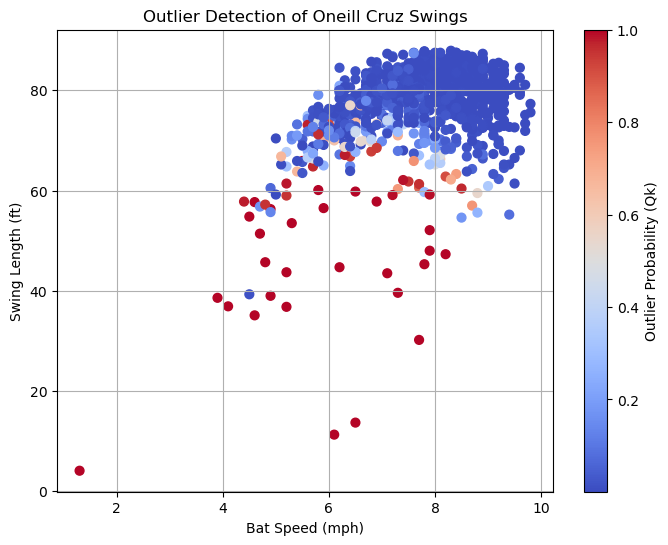

In [72]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    oneil_cruz['swing_length'], oneil_cruz['bat_speed'],
    c=Qk_outlier, cmap="coolwarm", s=40
)
plt.colorbar(scatter, label="Outlier Probability (Qk)")
plt.xlabel("Bat Speed (mph)")
plt.ylabel("Swing Length (ft)")
plt.title("Outlier Detection of Oneill Cruz Swings")
plt.grid(True)
plt.show()

In [78]:
oneil_cruz

pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0           FC  2024-06-23           89.6          -1.06           6.47   
1           FC  2024-07-11           88.4          -1.09           6.28   
2           ST  2024-07-11           79.6          -1.11           6.23   
3           FF  2024-07-11           91.5          -1.06           6.25   
4           FC  2024-07-11           87.3          -1.08           6.33   
5           SI  2024-07-11           92.1          -1.24           6.18   
6           ST  2024-07-11           79.4          -1.24           5.98   
7           SI  2024-07-11           92.8          -1.26           6.08   
8           CU  2024-07-11           76.6          -0.89           6.39   
9           FF  2024-09-26           92.1          -1.05           6.42   
10          ST  2024-09-26           80.6          -1.20           6.17   
11          CU  2024-09-26           76.7          -0.72           6.57   
12          SI  2024-09-26           93.3          -1.24           6.18   
13          SL  2024-07-07           91.8          -2.32           5.01   
14          SL  2024-04-15           89.0          -1.99           4.93   
15          FC  2024-05-06           81.6           1.26           6.41   
16          FC  2024-05-06           81.8           1.16           6.52   
17          FC  2024-05-06           80.7           1.43           6.50   
18          SI  2024-05-06           86.4           2.39           5.96   
19          FC  2024-05-06           82.4           1.89           6.36   
20          SI  2024-07-21           98.8           1.04           6.47   
21          FC  2024-07-21           93.9           0.85           6.48   
22          FC  2024-07-21           93.9           0.98           6.42   
23          SI  2024-07-19          100.2           0.95           6.50   
24          SI  2024-07-19          100.0           1.08           6.46   
25          CU  2024-06-08           75.4          -0.81           6.72   
26          SL  2024-06-08           87.2          -1.29           6.53   
27          CU  2024-06-08           78.9          -0.69           6.71   
28          SL  2024-06-08           87.8          -1.27           6.49   
29          CH  2024-06-08           84.4          -1.37           6.35   
30          CU  2024-06-08           77.5          -0.45           6.72   
31          CU  2024-06-08           76.9          -0.29           6.77   
32          FF  2024-09-05           97.0          -2.66           6.16   
33          SL  2024-09-07           87.0          -2.52           6.12   
34          SL  2024-09-07           85.8          -2.62           6.16   
35          FF  2024-09-07           96.0          -2.60           6.22   
36          FF  2024-09-07           95.2          -2.73           6.20   
37          CH  2024-04-04           84.1          -2.96           5.89   
38          SL  2024-04-04           86.4          -3.05           5.83   
39          SL  2024-04-04           84.6          -3.04           5.87   
40          FF  2024-05-12           93.0          -1.85           5.98   
41          SI  2024-09-26           94.7           2.92           6.06   
42          CU  2024-09-26           81.0           3.20           5.80   
43          SI  2024-04-23           95.2           2.97           6.12   
44          SL  2024-09-15           83.0          -1.67           5.37   
45          ST  2024-09-15           80.8          -1.66           5.21   
46          ST  2024-04-29           84.0          -1.59           5.93   
47          SL  2024-05-23           87.0          -2.23           6.47   
48          SI  2024-09-28           88.4           3.95           2.88   
49          FF  2024-04-29           98.4          -0.53           6.34   
50          FF  2024-04-29           95.9          -0.45           6.34   
51          FF  2024-04-29           96.5          -0.25           6.39   
52          SL  2024-04-29   

In [73]:
def categorize_qk(qk_value) :
    if qk_value >= 0.75:
        return 1
    elif 0.5 <= qk_value < 0.75:
        return 2
    elif 0.25 <= qk_value < 0.5:
        return 3
    else:
        return 4

oneil_cruz['Qk_bucket'] = oneil_cruz['Qk_outlier'].apply(categorize_qk)


In [79]:
oneil_cruz_specific = oneil_cruz[['Qk_outlier',
                                  'Qk_bucket',
                                  'woba_value',
                                  'estimated_woba_using_speedangle',
                                  'player_name', 
                                  'game_date', 
                                  'release_speed', 
                                  'description',
                                  'events', 
                                  'zone', 
                                  'delta_run_exp',
                                  'estimated_slg_using_speedangle',
                                  'delta_pitcher_run_exp',
                                  'bat_speed',
                                  'bat_speed_pred',
                                  'bat_speed_residual',
                                  'swing_length',
                                  'swing_length_pred',
                                  'swing_length_residual'
                                 ]].copy()
oneil_cruz_specific.sort_values(by='Qk_outlier', ascending=False, inplace=True)



In [80]:
oneil_cruz_specific

Qk_outlier  Qk_bucket  woba_value  estimated_woba_using_speedangle  \
18     1.000000          1         NaN                              NaN   
530    1.000000          1         NaN                              NaN   
889    1.000000          1         NaN                              NaN   
181    1.000000          1         NaN                              NaN   
771    1.000000          1        0.00                            0.088   
199    1.000000          1         NaN                              NaN   
142    1.000000          1         NaN                              NaN   
298    1.000000          1        0.00                            0.000   
114    1.000000          1         NaN                              NaN   
582    1.000000          1         NaN                              NaN   
910    1.000000          1         NaN                              NaN   
71     1.000000          1         NaN                              NaN   
106    1.000000          1         NaN                              NaN   
83     0.999999          1         NaN                              NaN   
375    0.999999          1         NaN                              NaN   
831    0.999997          1         NaN                              NaN   
112    0.999994          1         NaN                              NaN   
289    0.999993          1        0.00                            0.000   
326    0.999992          1         NaN                              NaN   
462    0.999981          1        0.00                            0.000   
216    0.999956          1        0.00                            0.000   
538    0.999927          1         NaN                              NaN   
801    0.999889          1         NaN                              NaN   
17     0.999795          1        0.00                            0.200   
510    0.999440          1         NaN                              NaN   
445    0.998523          1        0.00                            0.152   
473    0.998115          1        0.00                            0.070   
886    0.996664          1         NaN                              NaN   
72     0.995922          1         NaN                              NaN   
890    0.990872          1        0.00                            0.263   
763    0.990259          1        1.25                            0.869   
362    0.987243          1        0.00                            0.000   
321    0.980769          1         NaN                              NaN   
502    0.979482          1         NaN                              NaN   
888    0.978295          1         NaN                              NaN   
539    0.975398          1         NaN                              NaN   
240    0.968006          1         NaN                              NaN   
269    0.965334          1         NaN                              NaN   
923    0.959429          1        0.00                            0.000   
201    0.957015          1         NaN                              NaN   
139    0.950969          1         NaN                              NaN   
365    0.950542          1         NaN                              NaN   
46     0.945469          1        0.90                            0.512   
812    0.938606          1        0.00                            0.104   
82     0.935112          1        0.90                            0.845   
26     0.934040          1        0.00                            0.144   
231    0.929644          1        0.90                              NaN   
424    0.915554          1         NaN                              NaN   
223    0.910149          1         NaN                              NaN   
224    0.899683          1        0.90                            0.499   
209    0.893615          1        0.00                            0.506   
60     0.876560          1        0.00                            0.000   
515    0.766525          1    

In [105]:
oneil_cruz_contact = oneil_cruz_specific.dropna(subset=['estimated_woba_using_speedangle'])
oneil_cruz_contact_1 = oneil_cruz_specific[oneil_cruz_specific["Qk_bucket"] == 1]
oneil_cruz_contact_2 = oneil_cruz_specific[oneil_cruz_specific["Qk_bucket"] == 2]
oneil_cruz_contact_3 = oneil_cruz_specific[oneil_cruz_specific["Qk_bucket"] == 3]
oneil_cruz_contact_4 = oneil_cruz_specific[oneil_cruz_specific["Qk_bucket"] == 4]
oneil_cruz_contact_home_runs = oneil_cruz_specific[oneil_cruz_specific["woba_value"] == 2]
oneil_cruz_contact_doubles = oneil_cruz_specific[oneil_cruz_specific["events"] == "double"]
oneil_cruz_contact_singles = oneil_cruz_specific[oneil_cruz_specific["events"] == "single"]

In [116]:
print(oneil_cruz_contact_1.shape,
      oneil_cruz_contact_2.shape,
      oneil_cruz_contact_3.shape,
      oneil_cruz_contact_4.shape)

(55, 19) (18, 19) (28, 19) (859, 19)


In [112]:
oneil_cruz_specific['Qk_outlier'].median()
oneil_cruz_specific['Qk_outlier'].mean()

np.float32(0.09377453)

<Axes: xlabel='woba_value', ylabel='Qk_outlier'>

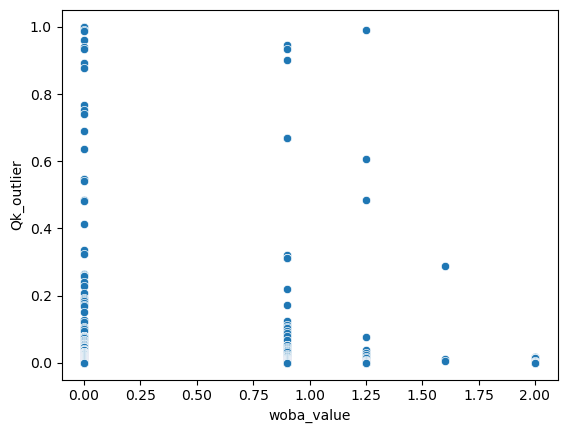

In [93]:
sns.scatterplot(data = oneil_cruz_contact, x = "woba_value", y = "Qk_outlier")


In [88]:
oneil_cruz_contact.shape

(436, 19)

In [ ]:
import jax 
import jax.numpy as jno
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

Y_data = oneil_cruz[["bat_speed_residual", "swing_length_residual"]].to_numpy()



In [25]:
import numpyro
import numpyro.distributions as dist

def swing_mixture_model(x, y):
    m = numpyro.sample("m", dist.Normal(0,5))
    b = numpyro.sample("b", dist.Normal(0,5))
    sigma_fg = numpyro.sample("sigma_fg", dist.HalfNormal(5))

    yb = numpyro.sample("y_bkg", dist.Normal(0,10))
    sigma_bg = numpyro.sample("sigma_bg", dist.HalfNormal(10))

    Q = numpyro.sample("Q", dist.Beta(1, 10))

    mu_fg = m * x + b

    loglik_fg = -0.5 * ((y - mu_fg) **2 / sigma_fg**2 + jnp.log(2 * jnp.pi * sigma_fg**2))
    loglik_bg = -0.5 * ((y - yb)**2 / sigma_bg**2 + jnp.log(2 * jnp.pi * sigma_bg **2))

    mixture_loglik = jnp.logaddexp(
        jnp.log(1 - Q) + loglike_fg,
        jnp.log(Q) + loglike_bg
    )

    total_loglik = jnp.sum(mixture_loglik)

    numpyro.factor("Likelihood", total_loglik)

    

In [ ]:
import jax
from numpyro.infer import MCMC,NUTS

nuts_kernel = NUTS(swing_mixture_model)

mcmc = MCMC(nuts_kernel, num_warmup = 500, num_samples = 1000, num_chains = 1)
mcmc.run(jax.random.PRNGKey(0), x = X_data, y = Y_data)
samples = mcmc.get_samples()


In [21]:
residuals = oneil_cruz[["bat_speed_residual", "swing_length_residual"]].to_numpy()
n = residuals.shape[0]

def swing_mixture_2d_model(residuals):
    n, d = residuals.shape  # d = 2

    # Mixture weight
    epsilon = numpyro.sample("epsilon", dist.Beta(1, 10))

    # Component 1 (good swings)
    mu_good = numpyro.sample("mu_good", dist.Normal(0, 10).expand([d]))
    scale_good = numpyro.sample("scale_good", dist.HalfNormal(5).expand([d]))

    # Component 2 (bad swings)
    mu_bad = numpyro.sample("mu_bad", dist.Normal(0, 10).expand([d]))
    scale_bad = numpyro.sample("scale_bad", dist.HalfNormal(20).expand([d]))

    with numpyro.plate("data", n):
        component_dists = [
            dist.Independent(dist.Normal(mu_good, scale_good), 1),
            dist.Independent(dist.Normal(mu_bad, scale_bad), 1)
        ]

        numpyro.sample(
            "obs",
            dist.MixtureGeneral(
                mixing_distribution=dist.Categorical(probs=jnp.array([1 - epsilon, epsilon])),
                component_distributions=component_dists
            ),
            obs=residuals
        )

nuts_kernel = NUTS(swing_mixture_2d_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500)
mcmc.run(jax.random.PRNGKey(0), residuals=residuals)
samples = mcmc.get_samples()

mcmc.print_summary()


predictive = Predictive(swing_mixture_2d_model, samples)
predictions = predictive(jax.random.PRNGKey(1), residuals=residuals)

residual_samples = predictions["obs"]  # shape: (num_samples, n, 2)

# Compute residual magnitudes
residual_norms = np.linalg.norm(residual_samples, axis=-1)  # (num_samples, n)

# Take mean norm over posterior samples
mean_residual_norm = residual_norms.mean(axis=0)

# Outliers: top 5% biggest residual norms
threshold = np.percentile(mean_residual_norm, 95)
outlier_flags = mean_residual_norm > threshold

# Add back to DataFrame
oneil_cruz["outlier_flag_joint"] = outlier_flags

sample: 100%|█| 1500/1500 [00:01<00:00, 896.70it/s, 7 steps of size 5.42e-01. ac


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      epsilon      0.09      0.02      0.09      0.07      0.12    518.89      1.00
    mu_bad[0]    -14.61      1.85    -14.59    -17.48    -11.64    630.59      1.00
    mu_bad[1]     -1.06      0.11     -1.05     -1.22     -0.87    626.16      1.00
   mu_good[0]      1.53      0.19      1.53      1.21      1.85    992.74      1.00
   mu_good[1]      0.11      0.02      0.11      0.08      0.15    830.69      1.00
 scale_bad[0]     12.95      1.10     12.84     11.05     14.67   1280.21      1.00
 scale_bad[1]      0.70      0.06      0.70      0.60      0.79   1694.95      1.00
scale_good[0]      4.96      0.15      4.96      4.70      5.18    630.38      1.00
scale_good[1]      0.55      0.01      0.55      0.52      0.57   1525.07      1.00

Number of divergences: 0


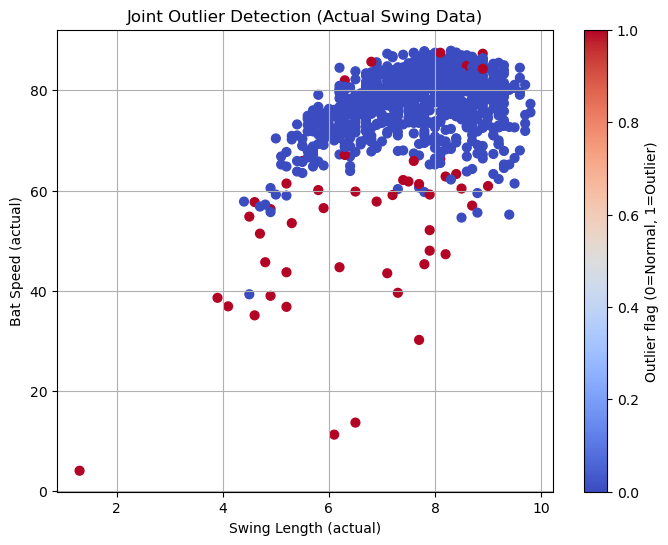

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(oneil_cruz["swing_length"], oneil_cruz["bat_speed"],
            c=oneil_cruz["outlier_flag_joint"], cmap="coolwarm", s=40)
plt.colorbar(label="Outlier flag (0=Normal, 1=Outlier)")
plt.xlabel("Swing Length (actual)")
plt.ylabel("Bat Speed (actual)")
plt.title("Joint Outlier Detection (Actual Swing Data)")
plt.grid(True)
plt.show()

In [14]:
oneil_cruz_fa = oneil_cruz[oneil_cruz["bat_speed"] < 42.5]
oneil_cruz_fa = oneil_cruz_fa[oneil_cruz_fa["outlier_flag"]==False]
oneil_cruz_fa

pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
491         FF  2024-07-26           97.4          -2.08           6.47   

       player_name  batter  pitcher     events      description  spin_dir  \
491  Ginkel, Kevin  665833   656464  strikeout  swinging_strike       NaN   

     spin_rate_deprecated  break_angle_deprecated  break_length_deprecated  \
491                   NaN                     NaN                      NaN   

     zone                               des game_type stand p_throws  \
491  11.0  Oneil Cruz strikes out swinging.         R     L        R   

    home_team away_team type  hit_location bb_type  balls  strikes  game_year  \
491        AZ       PIT    S           2.0     NaN      0        2       2024   

     pfx_x  pfx_z  plate_x  plate_z  on_3b     on_2b     on_1b  outs_when_up  \
491   -0.9   1.26    -0.83     4.97    NaN  663698.0  572191.0             1   

     inning inning_topbot  hc_x  hc_y  tfs_deprecated  tfs_zulu_deprecated  \
491       7           Top   NaN   NaN             NaN                  NaN   

     umpire  sv_id       vx0         vy0       vz0        ax         ay  \
491     NaN    NaN  5.465737 -141.700594 -1.397962 -13.41887  34.382049   

            az  sz_top  sz_bot  hit_distance_sc  launch_speed  launch_angle  \
491 -15.116924    3.86     1.8              NaN           NaN           NaN   

     effective_speed  release_spin_rate  release_extension  game_pk  \
491             97.9             2400.0                6.7   747174   

     fielder_2  fielder_3  fielder_4  fielder_5  fielder_6  fielder_7  \
491     672515     572233     606466     553993     672695     666971   

     fielder_8  fielder_9  release_pos_y  estimated_ba_using_speedangle  \
491     677950     682998          53.79                            NaN   

     estimated_woba_using_speedangle  woba_value  woba_denom  babip_value  \
491                              0.0         0.0         1.0          0.0   

     iso_value  launch_speed_angle  at_bat_number  pitch_number  \
491        0.0                 NaN             55             3   

          pitch_name  home_score  away_score  bat_score  fld_score  \
491  4-Seam Fastball           4           3          3          4   

     post_away_score  post_home_score  post_bat_score  post_fld_score  \
491                3                4               3               4   

    if_fielding_alignment of_fielding_alignment  spin_axis  \
491              Standard              Standard      223.0   

     delta_home_win_exp  delta_run_exp  bat_speed  swing_length  \
491               0.084         -0.301       39.3           4.5   

     estimated_slg_using_speedangle  delta_pitcher_run_exp  hyper_speed  \
491                             NaN                  0.301          NaN   

     home_score_diff  bat_score_diff  home_win_exp  bat_win_exp  \
491                1              -1         0.626        0.374   

     age_pit_legacy  age_bat_legacy  age_pit  age_bat  n_thruorder_pitcher  \
491              30              25       30       26                    1   

     n_priorpa_thisgame_player_at_bat  pitcher_days_since_prev_game  \
491                                 3                           3.0   

     batter_days_since_prev_game  pitcher_days_until_next_game  \
491                          2.0                           2.0   

     batter_days_until_next_game  api_break_z_with_gravity  api_break_x_arm  \
491                          1.0                      1.15              0.9   

     api_break_x_batter_in  arm_angle  total_pitches_game preferred_pitch  \
491                   -0.9       39.6                  11              FF   

     avg_preferred_ff_velocity batter_name  bat_speed_pred  swing_length_pred  \
491                       96.0  Oneil Cruz       42.710809            4.63773   

     bat_speed_residual  swing_length_residual  predicted_bat_speed  residual  \
491           -3.410809               -0.13773   

In [7]:
#filtered = oneil_cruz[
#    (oneil_cruz["bat_speed"] > 60) &
#    (oneil_cruz["swing_length"] >= 8)
#]
filtered_outliers = oneil_cruz[oneil_cruz["outlier_flag"] ==True]

In [50]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [15]:
filtered_outliers

pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
17          FC  2024-05-06           80.7           1.43           6.50   
18          SI  2024-05-06           86.4           2.39           5.96   
25          CU  2024-06-08           75.4          -0.81           6.72   
69          SL  2024-06-21           85.3           1.12           6.43   
71          FF  2024-04-26           92.3           1.97           5.15   
81          ST  2024-09-24           79.1           4.04           4.22   
83          ST  2024-04-25           77.3           4.15           4.40   
106         FF  2024-05-23           97.2           0.97           6.40   
112         FF  2024-07-24           93.1           0.36           6.52   
142         FF  2024-08-04           95.6           3.36           5.27   
150         SL  2024-09-19           83.0           2.21           5.26   
181         FF  2024-09-09           97.5           1.85           6.20   
193         CH  2024-08-13           88.2          -3.40           5.23   
199         SL  2024-06-28           84.4           2.00           6.44   
223         CH  2024-04-05           84.7          -2.44           5.68   
240         SL  2024-06-16           90.5          -1.08           6.36   
241         SL  2024-06-16           90.3          -0.95           6.42   
286         SL  2024-09-07           85.8           2.13           5.81   
298         CH  2024-09-19           88.0          -1.50           5.80   
375         SI  2024-08-25           93.2          -1.65           6.21   
382         SL  2024-07-30           81.1           2.78           5.64   
397         FC  2024-06-02           90.9          -2.67           6.09   
461         KC  2024-05-04           76.8           1.87           6.56   
462         KC  2024-05-04           75.8           1.95           6.50   
496         CU  2024-06-29           86.1          -2.18           6.29   
501         CH  2024-04-19           85.0          -1.90           5.08   
510         FF  2024-09-07           91.9           1.82           5.79   
515         SL  2024-09-07           87.6           2.05           5.68   
530         CH  2024-04-25           88.2          -3.63           5.11   
538         CU  2024-08-22           82.5           3.61           5.40   
563         CH  2024-06-21           84.9          -1.19           6.22   
567         CH  2024-04-19           84.4          -0.81           5.72   
574         SL  2024-09-24           84.1          -2.89           5.56   
581         ST  2024-09-04           80.5           3.46           5.38   
582         ST  2024-09-04           79.3           3.21           5.28   
763         SL  2024-08-12           90.4           2.59           5.18   
771         ST  2024-04-21           82.8           2.57           5.66   
772         ST  2024-05-19           81.9           3.19           5.48   
783         FC  2024-04-08           87.6           1.38           6.22   
801         SI  2024-04-12           92.5           1.76           6.36   
803         CH  2024-04-12           82.8           1.88           6.33   
830         SL  2024-04-30           88.7          -2.42           6.05   
831         FF  2024-09-11           90.8          -1.54           6.08   
889         CU  2024-08-16           82.7          -1.55           5.80   
890         FS  2024-08-16           84.4          -1.63           5.71   
910         CU  2024-08-03           80.8           1.35           6.61   
915         CH  2024-07-13           81.8          -0.26           6.69   
930         CU  2024-06-04           84.5          -1.31           6.13   

                  player_name  batter  pitcher     events  \
17            Anderson, Tyler  665833   542881  field_out   
18            Anderson, Tyler  665833   542881        NaN   
25   Woods Richardson, Simeon  665833   680573        NaN   
69               Poche, Colin  665833   621363  strikeout   
71             Harrison

In [9]:
filtered_outliers

pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
17          FC  2024-05-06           80.7           1.43           6.50   
18          SI  2024-05-06           86.4           2.39           5.96   
25          CU  2024-06-08           75.4          -0.81           6.72   
69          SL  2024-06-21           85.3           1.12           6.43   
71          FF  2024-04-26           92.3           1.97           5.15   
81          ST  2024-09-24           79.1           4.04           4.22   
83          ST  2024-04-25           77.3           4.15           4.40   
106         FF  2024-05-23           97.2           0.97           6.40   
112         FF  2024-07-24           93.1           0.36           6.52   
142         FF  2024-08-04           95.6           3.36           5.27   
150         SL  2024-09-19           83.0           2.21           5.26   
181         FF  2024-09-09           97.5           1.85           6.20   
193         CH  2024-08-13           88.2          -3.40           5.23   
199         SL  2024-06-28           84.4           2.00           6.44   
223         CH  2024-04-05           84.7          -2.44           5.68   
240         SL  2024-06-16           90.5          -1.08           6.36   
241         SL  2024-06-16           90.3          -0.95           6.42   
286         SL  2024-09-07           85.8           2.13           5.81   
298         CH  2024-09-19           88.0          -1.50           5.80   
375         SI  2024-08-25           93.2          -1.65           6.21   
382         SL  2024-07-30           81.1           2.78           5.64   
397         FC  2024-06-02           90.9          -2.67           6.09   
461         KC  2024-05-04           76.8           1.87           6.56   
462         KC  2024-05-04           75.8           1.95           6.50   
496         CU  2024-06-29           86.1          -2.18           6.29   
501         CH  2024-04-19           85.0          -1.90           5.08   
510         FF  2024-09-07           91.9           1.82           5.79   
515         SL  2024-09-07           87.6           2.05           5.68   
530         CH  2024-04-25           88.2          -3.63           5.11   
538         CU  2024-08-22           82.5           3.61           5.40   
563         CH  2024-06-21           84.9          -1.19           6.22   
567         CH  2024-04-19           84.4          -0.81           5.72   
574         SL  2024-09-24           84.1          -2.89           5.56   
581         ST  2024-09-04           80.5           3.46           5.38   
582         ST  2024-09-04           79.3           3.21           5.28   
763         SL  2024-08-12           90.4           2.59           5.18   
771         ST  2024-04-21           82.8           2.57           5.66   
772         ST  2024-05-19           81.9           3.19           5.48   
783         FC  2024-04-08           87.6           1.38           6.22   
801         SI  2024-04-12           92.5           1.76           6.36   
803         CH  2024-04-12           82.8           1.88           6.33   
830         SL  2024-04-30           88.7          -2.42           6.05   
831         FF  2024-09-11           90.8          -1.54           6.08   
889         CU  2024-08-16           82.7          -1.55           5.80   
890         FS  2024-08-16           84.4          -1.63           5.71   
910         CU  2024-08-03           80.8           1.35           6.61   
915         CH  2024-07-13           81.8          -0.26           6.69   
930         CU  2024-06-04           84.5          -1.31           6.13   

                  player_name  batter  pitcher     events  \
17            Anderson, Tyler  665833   542881  field_out   
18            Anderson, Tyler  665833   542881        NaN   
25   Woods Richardson, Simeon  665833   680573        NaN   
69               Poche, Colin  665833   621363  strikeout   
71             Harrison

In [17]:
import seaborn as sns

<Axes: xlabel='plate_z', ylabel='swing_length_residual'>

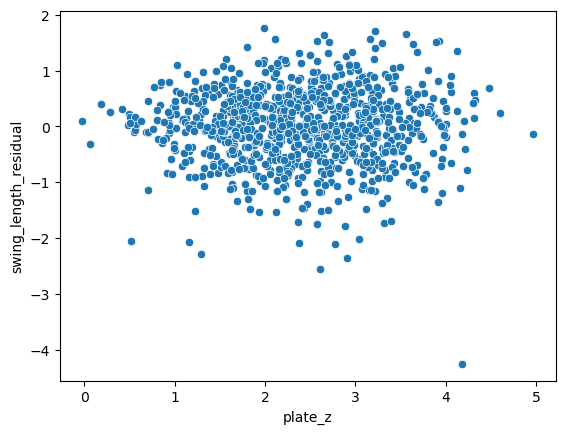

In [24]:
sns.scatterplot(data=oneil_cruz, x = 'plate_z', y = 'swing_length_residual')

<Axes: xlabel='plate_z', ylabel='swing_length'>

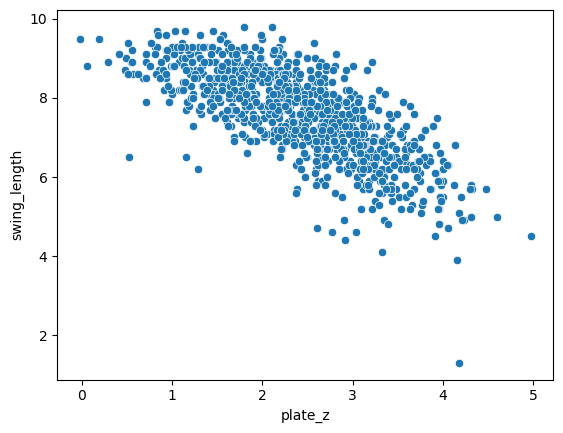

In [18]:
sns.scatterplot(data =oneil_cruz, x = 'plate_x', y = 'swing_length')

<Axes: xlabel='plate_z', ylabel='swing_length'>

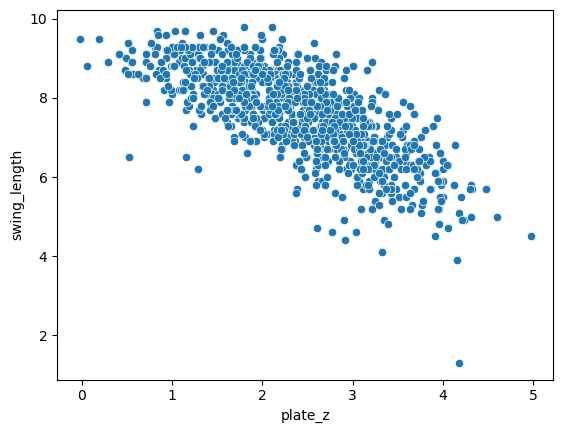

In [49]:
sns.scatterplot(data =oneil_cruz, x = 'plate_z', y = 'swing_length')

<Axes: xlabel='plate_x', ylabel='bat_speed'>

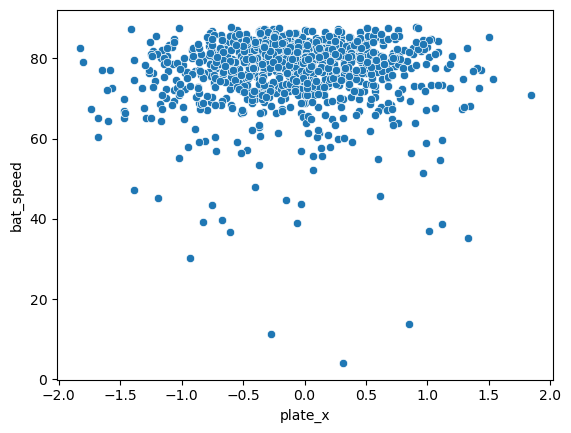

In [19]:
sns.scatterplot(data =oneil_cruz, x = 'plate_x', y = 'bat_speed')

<Axes: xlabel='plate_z', ylabel='bat_speed'>

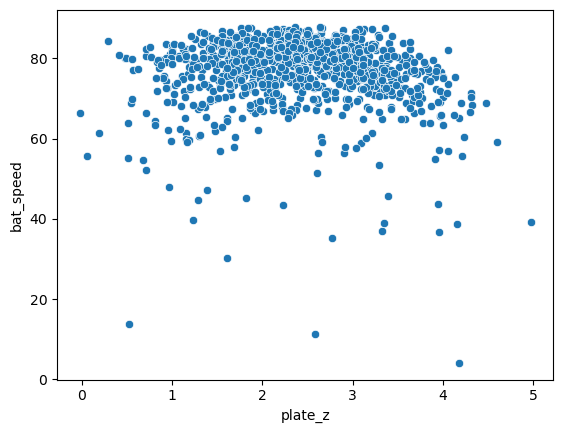

In [20]:
sns.scatterplot(data =oneil_cruz, x = 'plate_z', y = 'bat_speed')

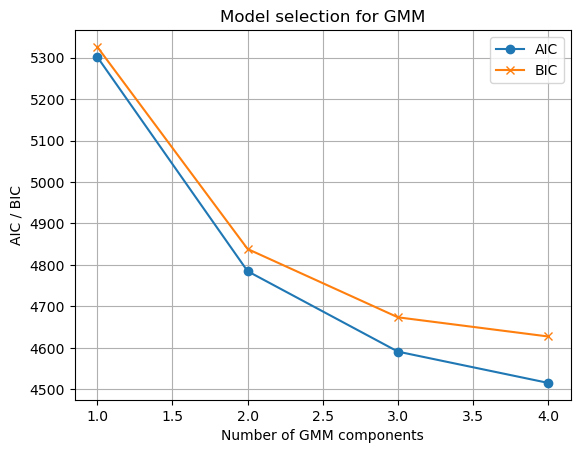

In [34]:
plt.plot(ks, aics, label='AIC', marker='o')
plt.plot(ks, bics, label='BIC', marker='x')
plt.xlabel("Number of GMM components")
plt.ylabel("AIC / BIC")
plt.title("Model selection for GMM")
plt.legend()
plt.grid(True)
plt.show()